In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pathlib

paths = dict(
    field_loads='/proj/gallippilab/users/joeyr/batch_load_simulations/loads',
    dyna_sims='/proj/gallippilab/users/joeyr/dyna_simulations',
)

paths = {k: pathlib.Path(v) for k,v in paths.items()}

# Single Test Simulations

UniformCoordinates(xmin=-1.5, xmax=0.0, ymin=0.0, ymax=1.5, zmin=-4.0, zmax=0.0, nx=43, ny=43, nz=111, grid_size=0.0003657957244655582, dx=0.03571428571428581, dy=0.03571428571428571, dz=0.036363636363636154)


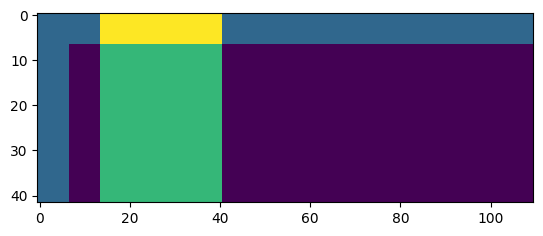

In [8]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic


txer = 'vf73'
fnum = 3.0
att = 0.6
fd = 25

load_curve_id = 1
normalization_isppa = 2500
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

mat = Elastic(density=1, E=26*1e3, nu=0.499)
mat2 = Elastic(density=1, E=2*26*1e3, nu=0.499)
# mat = KelvinMaxwellViscoelastic(density=1, E=26*1e3, nu=0.499, eta=0.01)

struct_list = [
    # Structure(
    #     shape = 'rectangle',
    #     args = [-1, -0.5, 0, 0.5, -4, -2],
    #     material = mat2,
    # ),
    # Structure(
    #     shape = 'sphere',
    #     args = [0,0,-2,1],
    #     material = mat2,
    # ),
    Structure(
        shape = 'cylinder',
        args = [0,-3,1.041*0.5],
        material = mat2,
    ),
]

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 1*(c / fc)  # m
coords = UniformCoordinates(
    grid_size=grid_size,
    xmin=-1.5, xmax=0.0,  # ele
    ymin=0.0, ymax=1.5,  # lat
    zmin=-4.0, zmax=0.0   # ax
)
print(coords)
symmetry = 'q'
sims_path = paths['dyna_sims'] / 'test_writer'


mesh = UniformMesh(coords, symmetry, mat)

mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])
mesh.add_struct_list(struct_list)
mesh.constrain_boundary_nodes()

mesh.set_control(end_time=6e-3)
mesh.set_database(dt=2e-5, create_node_set=True)

material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"
# material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v={mesh.materials[0]['material'].eta}"


# load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
# field_load_file = paths['field_loads'] / f"{load_name}.mat"
# mesh.add_load_curve(
#     load_curve_id, 'multipush', multipush_params_list
# )
# mesh.add_field_arf_load(
#     field_load_file, normalization_isppa, load_curve_id
# )

# load_folder_name = load_name + f",isppa={normalization_isppa}"
# mesh.write_all_dyna_cards(
#     sims_path, load_folder_name, material_folder_name
# )

elems = mesh.get_elems_3d()

plt.imshow(elems[:, 0, :]['pid'])


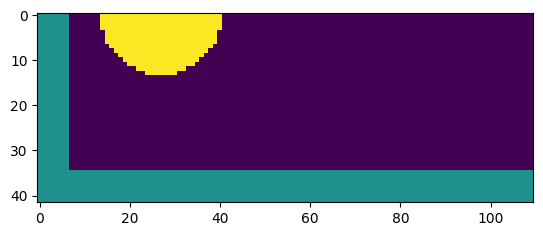

In [9]:
plt.imshow(elems[-1, :, :]['pid'])

In [42]:
np.unique(mesh.elems['pid'])

array([1, 2, 3, 4], dtype=int32)

In [5]:
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic


# mat1 = KelvinMaxwellViscoelastic(density=1, E=25*1e3, nu=0.499, eta=0.01)
# mat1 = KelvinMaxwellViscoelastic(density=1, E=26.11*1e3, nu=0.499, eta=2.34)
mat1 = Elastic(density=1, E=10*1e3, nu=0.499)

coords = UniformCoordinates(
    # nx=51, ny=51, nz=101,
    nx=21, ny=21, nz=51,
    xmin=-2.0, xmax=0.0,  # ele
    ymin=0.0, ymax=2.0,  # lat
    zmin=-4.0, zmax=0.0   # ax
)
symmetry = 'q'
mesh_template = UniformMesh(coords, symmetry, mat1)

mesh_template.add_pml(pml_thickness=7, exclude_faces=['zmax'])
# mesh.add_struct_list(struct_list)
mesh_template.constrain_boundary_nodes()

mesh_template.set_control(end_time=4.5e-3)
mesh_template.set_database(dt=2e-5)


In [16]:
import copy
from itertools import product

sims_path = paths['dyna_sims'] / 'test_writer'

load_curve_id = 1
normalization_isppa = 1000

txer = 'vf73'
fnum = 1.5
att = 0.5
fd_arr = [15]

t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 5
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

params = product(fd_arr)

for (fd,) in params:
    mesh = copy.deepcopy(mesh_template)

    load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
    field_load_file = paths['field_loads'] / f"{load_name}.mat"
    mesh.add_load_curve(load_curve_id, 'multipush', multipush_params_list)
    mesh.add_field_arf_load(field_load_file, normalization_isppa, load_curve_id)

    load_folder_name = load_name
    # material_folder_name = f"e={mesh_template.materials[0]['material'].E/1e3:.0f},v={mesh_template.materials[0]['material'].eta}"
    material_folder_name = f"e={mesh_template.materials[0]['material'].E/1e3:.0f},v=0.0"
    mesh.write_all_dyna_cards(sims_path, load_folder_name, material_folder_name)


# PML Thickness Test

In [4]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic

txer = 'vf73'
fnum = 3.0
att = 0.6
fd = 15

load_curve_id = 1
normalization_isppa = 1000
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

# pml_thickness_arr = [1, 5, 11, 15, 21]
pml_thickness_arr = [15, 21]

mat = Elastic(density=1, E=26*1e3, nu=0.499)

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 0.4*(c / fc)  # m

for pml_thickness in pml_thickness_arr:
    coords = UniformCoordinates(
        grid_size=grid_size,
        xmin=-1.0, xmax=0.0,  # ele
        ymin=0.0, ymax=1.0,  # lat
        zmin=-3.0, zmax=0.0   # ax
    )
    print(coords)
    symmetry = 'q'
    sims_path = paths['dyna_sims'] / 'pml_thickness_test' / \
        f"pml_thickness={pml_thickness}"

    mesh = UniformMesh(coords, symmetry, mat)

    mesh.add_pml(pml_thickness=pml_thickness)
    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5)

    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"

    load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
    field_load_file = paths['field_loads'] / f"{load_name}.mat"
    mesh.add_load_curve(
        load_curve_id, 'multipush', multipush_params_list
    )
    mesh.add_field_arf_load(
        field_load_file, normalization_isppa, load_curve_id
    )

    load_folder_name = load_name
    mesh.write_all_dyna_cards(
        sims_path, load_folder_name, material_folder_name
    )


UniformCoordinates(xmin=-1.0, xmax=0.0, ymin=0.0, ymax=1.0, zmin=-3.0, zmax=0.0, nx=69, ny=69, nz=207, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.01456310679611672)
UniformCoordinates(xmin=-1.0, xmax=0.0, ymin=0.0, ymax=1.0, zmin=-3.0, zmax=0.0, nx=69, ny=69, nz=207, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.01456310679611672)


# Lat/Ele Mesh Size Test
Includes pml thickness testing

In [5]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic

txer = 'vf73'
fnum = 3.0
att = 0.6
fd = 15

load_curve_id = 1
normalization_isppa = 1000
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

pml_thickness_arr = [5, 11]
mesh_thickness_arr = [0.5, 1.0, 1.5, 2.0]

params = product(pml_thickness_arr, mesh_thickness_arr)

mat = Elastic(density=1, E=26*1e3, nu=0.499)

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 0.4*(c / fc)  # m

for (pml_thickness, mesh_thickness) in params:
    coords = UniformCoordinates(
        grid_size=grid_size,
        xmin=-1*mesh_thickness, xmax=0.0,  # ele
        ymin=0.0, ymax=mesh_thickness,  # lat
        zmin=-3.0, zmax=0.0   # ax
    )
    print(coords)
    symmetry = 'q'
    sims_path = paths['dyna_sims'] / 'mesh_thickness_test' / \
        f"pml_thickness={pml_thickness},mesh_thickness={mesh_thickness:.1f}"

    mesh = UniformMesh(coords, symmetry, mat)

    mesh.add_pml(pml_thickness=pml_thickness)
    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5)

    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"

    load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
    field_load_file = paths['field_loads'] / f"{load_name}.mat"
    mesh.add_load_curve(
        load_curve_id, 'multipush', multipush_params_list
    )
    mesh.add_field_arf_load(
        field_load_file, normalization_isppa, load_curve_id
    )

    load_folder_name = load_name
    mesh.write_all_dyna_cards(
        sims_path, load_folder_name, material_folder_name
    )


UniformCoordinates(xmin=-0.5, xmax=0.0, ymin=0.0, ymax=0.5, zmin=-3.0, zmax=0.0, nx=35, ny=35, nz=207, grid_size=0.0001463182897862233, dx=0.01470588235294118, dy=0.014705882352941176, dz=0.01456310679611672)
UniformCoordinates(xmin=-1.0, xmax=0.0, ymin=0.0, ymax=1.0, zmin=-3.0, zmax=0.0, nx=69, ny=69, nz=207, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.01456310679611672)
UniformCoordinates(xmin=-1.5, xmax=0.0, ymin=0.0, ymax=1.5, zmin=-3.0, zmax=0.0, nx=103, ny=103, nz=207, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.01456310679611672)
UniformCoordinates(xmin=-2.0, xmax=0.0, ymin=0.0, ymax=2.0, zmin=-3.0, zmax=0.0, nx=137, ny=137, nz=207, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.01456310679611672)
UniformCoordinates(xmin=-0.5, xmax=0.0, ymin=0.0, ymax=0.5, zmin=-3.0, zmax=0.0, nx=35, ny=35, nz=207, grid_size=0.0001463182897862233, dx=0.0147058823529411

# Zmax = 0 Test Setup

In [5]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic

txer = 'vf73'
fnum = 3.0
att = 0.6
fd = 15

load_curve_id = 1
normalization_isppa = 1000
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

zmax_arr = [0.0, -0.15, -0.5]
zmax_pml_arr = [True, False]

mat = Elastic(density=1, E=26*1e3, nu=0.499)

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 0.5*(c / fc)  # m

params = product(zmax_arr, zmax_pml_arr)

for (zmax, zmax_has_pml) in params:
    coords = UniformCoordinates(
        grid_size=grid_size,
        xmin=-2.0, xmax=0.0,  # ele
        ymin=0.0, ymax=2.0,  # lat
        zmin=-3.0, zmax=zmax   # ax
    )
    symmetry = 'q'
    sims_path = paths['dyna_sims'] / 'zmax_tests' / f"zmax={zmax:.2f},zmax_has_pml={str(zmax_has_pml)}"

    mesh = UniformMesh(coords, symmetry, mat)

    if zmax_has_pml:
        mesh.add_pml(pml_thickness=7)
    else:
        mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])

    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5)

    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"

    load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
    field_load_file = paths['field_loads'] / f"{load_name}.mat"
    mesh.add_load_curve(
        load_curve_id, 'multipush', multipush_params_list
    )
    mesh.add_field_arf_load(
        field_load_file, normalization_isppa, load_curve_id
    )

    load_folder_name = load_name
    mesh.write_all_dyna_cards(
        sims_path, load_folder_name, material_folder_name
    )


# Convergence Study Setup

In [4]:
from itertools import product
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic

# setup convergence study

txer = 'vf73'
fnum = 3.0
att = 0.5
fd = 15

load_curve_id = 1
normalization_isppa = 1000
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 5
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

mesh_size_list = [
    [25, 25, 51],
    [51, 51, 101],
    [75, 75, 151],
    [101, 101, 201],
]

material_list = [
    # Elastic(density=1, E=10*1e3, nu=0.499),
    # Elastic(density=1, E=100*1e3, nu=0.499),
    KelvinMaxwellViscoelastic(density=1, E=10*1e3, nu=0.499, eta=0.01),
    KelvinMaxwellViscoelastic(density=1, E=100*1e3, nu=0.499, eta=0.01),
    KelvinMaxwellViscoelastic(density=1, E=10*1e3, nu=0.499, eta=8),
    KelvinMaxwellViscoelastic(density=1, E=100*1e3, nu=0.499, eta=8),
]
# material_list = [
#     # Elastic(density=1, E=10*1e3, nu=0.499),
#     # Elastic(density=1, E=100*1e3, nu=0.499),
#     KelvinMaxwellViscoelastic(density=1, E=10*1e3, nu=0.499, eta=0.01, elform=24),
#     KelvinMaxwellViscoelastic(density=1, E=100*1e3, nu=0.499, eta=0.01, elform=24),
#     KelvinMaxwellViscoelastic(density=1, E=10*1e3, nu=0.499, eta=8, elform=24),
#     KelvinMaxwellViscoelastic(density=1, E=100*1e3, nu=0.499, eta=8, elform=24),
# ]

for mesh_size in mesh_size_list:

    coords = UniformCoordinates(
        nx=mesh_size[0], ny=mesh_size[1], nz=mesh_size[2],
        xmin=-2.0, xmax=0.0,  # ele
        ymin=0.0, ymax=2.0,  # lat
        zmin=-4.0, zmax=0.0   # ax
    )
    symmetry = 'q'
    sims_path = paths['dyna_sims'] / 'convergence_study_fnum=3.0' / f'mesh_size={str(mesh_size).replace(" ", "")}'

    for mat_idx, mat in enumerate(material_list):

        if mat_idx == 0:
            mesh = UniformMesh(coords, symmetry, mat)

            mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])
            mesh.constrain_boundary_nodes()

            mesh.set_control(end_time=6e-3)
            mesh.set_database(dt=2e-5)

            load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
            field_load_file = paths['field_loads'] / f"{load_name}.mat"
            mesh.add_load_curve(load_curve_id, 'multipush', multipush_params_list)
            mesh.add_field_arf_load(
                field_load_file, normalization_isppa, load_curve_id
            )
            # material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"
        else:
            mesh.change_material(mat, 0)

        material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v={mesh.materials[0]['material'].eta}"

        load_folder_name = load_name
        mesh.write_all_dyna_cards(sims_path, load_folder_name, material_folder_name)


# Phantom Matched Simulations
Cylindircal phantom has 26kPa background with 1540m/s speed of sound and 0.66dB/cm/MHz attenuation

Phantom data scanner acquisition location: 

J:\Joey\projects\testing\VisR_SDUV_Acquisitions\antares_scripts\experiments\cylinder_phantom_sduv-visr-arfi

In [5]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic

txer = 'vf73'
fnum = 3.0
att_arr = [0.6]
fd = 25

load_curve_id = 1
normalization_isppa_arr = [2500]
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

params = product(att_arr, normalization_isppa_arr)

material_list = [
    Elastic(density=1, E=26*1e3, nu=0.499),
    # KelvinMaxwellViscoelastic(density=1, E=26*1e3, nu=0.499, eta=0.01),
]

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 0.5*(c / fc)  # m
coords = UniformCoordinates(
    grid_size=grid_size,
    xmin=-1.5, xmax=0.0,  # ele
    ymin=0.0, ymax=1.5,  # lat
    zmin=-4.0, zmax=0.0   # ax
)
print(coords)
symmetry = 'q'
sims_path = paths['dyna_sims'] / 'phantom_matched_fd=25_ithresh=25' 

for mat_idx, mat in enumerate(material_list):

    # if mat_idx == 0:
    mesh = UniformMesh(coords, symmetry, mat)

    mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])
    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5)

    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"
    # else:
    #     mesh.change_material(mat, 0)
    # material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v={mesh.materials[0]['material'].eta}"

    for (att, normalization_isppa) in params:
        mesh_out = copy.deepcopy(mesh)

        load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
        field_load_file = paths['field_loads'] / f"{load_name}.mat"
        mesh_out.add_load_curve(
            load_curve_id, 'multipush', multipush_params_list
        )
        mesh_out.add_field_arf_load(
            field_load_file, normalization_isppa, load_curve_id
        )

        load_folder_name = load_name + f",isppa={normalization_isppa}"
        mesh_out.write_all_dyna_cards(
            sims_path, load_folder_name, material_folder_name
        )


UniformCoordinates(xmin=-1.5, xmax=0.0, ymin=0.0, ymax=1.5, zmin=-4.0, zmax=0.0, nx=83, ny=83, nz=219, grid_size=0.0001828978622327791, dx=0.018292682926829285, dy=0.018292682926829267, dz=0.0183486238532109)


In [15]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic


txer = 'vf73'
fnum = 3.0
att_arr = [0.3, 0.6, 0.9]
fd_arr = [15, 25, 35]

load_curve_id = 1
normalization_isppa = 2500
t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

mat = Elastic(density=1, E=26*1e3, nu=0.499)
inc_type_dict = {
    'type1': Elastic(density=1, E=6.5*1e3, nu=0.499),
    'type2': Elastic(density=1, E=15.53*1e3, nu=0.499),
    'type3': Elastic(density=1, E=49*1e3, nu=0.499),
    'type4': Elastic(density=1, E=88*1e3, nu=0.499),
}

inc_diameter_arr = [0.649, 1.041, 1.667]  # cm

for (inc_type, inc_diameter) in product(inc_type_dict.keys(), inc_diameter_arr):
    # sims_path = paths['dyna_sims'] / 'phantom_matched_cylinder' / f"inc_type={inc_type},inc_diam={inc_diameter:.3f}"
    sims_path = paths['dyna_sims'] / 'phantom_matched_cylinder_node_set' / f"inc_type={inc_type},inc_diam={inc_diameter:.3f}"

    struct_list = [
        Structure(
            shape='cylinder',
            args=[0, -3, inc_diameter*0.5],
            material=inc_type_dict[inc_type],
        ),
    ]

    c = 1540  # m/s
    fc = 4.21*1e6  # Hz
    grid_size = 0.4*(c / fc)  # m
    coords = UniformCoordinates(
        grid_size=grid_size,
        xmin=-1.5, xmax=0.0,  # ele
        ymin=0.0, ymax=1.5,  # lat
        zmin=-4.5, zmax=0.0   # ax
    )
    print(coords)
    symmetry = 'q'

    mesh = UniformMesh(coords, symmetry, mat)

    mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])
    mesh.add_struct_list(struct_list)
    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5, create_node_set=True)

    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"
    for (fd, att) in product(fd_arr, att_arr):

        mesh_out = copy.deepcopy(mesh)

        load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
        field_load_file = paths['field_loads'] / f"{load_name}.mat"
        mesh_out.add_load_curve(
            load_curve_id, 'multipush', multipush_params_list
        )
        mesh_out.add_field_arf_load(
            field_load_file, normalization_isppa, load_curve_id
        )

        load_folder_name = load_name + f",isppa={normalization_isppa}"
        mesh_out.write_all_dyna_cards(
            sims_path, load_folder_name, material_folder_name
        )
        break
    break


UniformCoordinates(xmin=-1.5, xmax=0.0, ymin=0.0, ymax=1.5, zmin=-4.5, zmax=0.0, nx=103, ny=103, nz=309, grid_size=0.0001463182897862233, dx=0.014705882352941124, dy=0.014705882352941176, dz=0.014610389610389518)


# Quarter vs no symmetry

In [4]:
from itertools import product
import copy
import fem

from fem.dyna.mesh import UniformCoordinates, UniformMesh
from fem.dyna._structure import Structure
from fem.dyna.material import Elastic, KelvinMaxwellViscoelastic


# mat1 = KelvinMaxwellViscoelastic(density=1, E=25*1e3, nu=0.499, eta=0.01)
# mat1 = KelvinMaxwellViscoelastic(density=1, E=26.11*1e3, nu=0.499, eta=2.34)
mat1 = Elastic(density=1, E=26*1e3, nu=0.499)

c = 1540  # m/s
fc = 4.21*1e6  # Hz
grid_size = 0.5*(c / fc)  # m

nsym_coords = UniformCoordinates(
    grid_size=grid_size,
    xmin=-1.5, xmax=1.5,  # ele
    ymin=-2.0, ymax=2.0,  # lat
    zmin=-3.0, zmax=0.0   # ax
)
symmetry = 'n'
psym_mesh = UniformMesh(nsym_coords, symmetry, mat1)

qsym_coords = UniformCoordinates(
    grid_size=grid_size,
    xmin=-1.5, xmax=0.0,  # ele
    ymin=0.0, ymax=2.0,  # lat
    zmin=-3.0, zmax=0.0   # ax
)
symmetry = 'q'
qsym_mesh = UniformMesh(qsym_coords, symmetry, mat1)

load_curve_id = 1
normalization_isppa = 2500

txer = 'vf73'
fnum = 3.0
att = 0.6
fd = 15

t_arf = 70e-6
dt = 1e-6
n_arf = 2
tracks_between = 4
prf = 10e3
multipush_params_list = [t_arf, dt, n_arf, tracks_between, prf]

for mesh in (qsym_mesh, psym_mesh):

    sims_path = paths['dyna_sims'] / 'symmetry_test' / f"symmetry={mesh.symmetry}"

    mesh.add_pml(pml_thickness=7, exclude_faces=['zmax'])
    mesh.constrain_boundary_nodes()

    mesh.set_control(end_time=6e-3)
    mesh.set_database(dt=2e-5)

    load_name = f"txer={txer},fd=[0,0,{fd}],fnum={fnum},att={att}"
    field_load_file = paths['field_loads'] / f"{load_name}.mat"
    mesh.add_load_curve(load_curve_id, 'multipush', multipush_params_list)
    mesh.add_field_arf_load(
        field_load_file, normalization_isppa, load_curve_id)

    load_folder_name = load_name
    # material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v={mesh.materials[0]['material'].eta}"
    material_folder_name = f"e={mesh.materials[0]['material'].E/1e3:.0f},v=0.0"
    mesh.write_all_dyna_cards(
        sims_path, load_folder_name, material_folder_name)


# More Integration Points Convergence Study

Also add testing QVisR with artificial signals and plotting the predicated e,v to prelim doc

Triangular latice instead of square so waves can propagate diagonally?

# Hourglassing Control Test
Setup simulation with known high frequency oscillations and add hourglass control card to see if mesh refinement is needed